In [1]:
# Import useful libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook # display a progress bar 

In [2]:
# Load the dataset 
path = '../input/' # input file path

labels = pd.read_csv(path+'train_labels.csv') # read training labels --> 0: no tumor, 1: tumor
train_path = path + 'train/'
test_path = path + 'test/'
# quick look at the label stats
labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [3]:
# read image function
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We convert it to rgb for visualization purposes
    rgb_img = cv2.cvtColor(bgr_img,cv2.COLOR_BGR2RGB)
    return rgb_img

# Sample Image Visualization

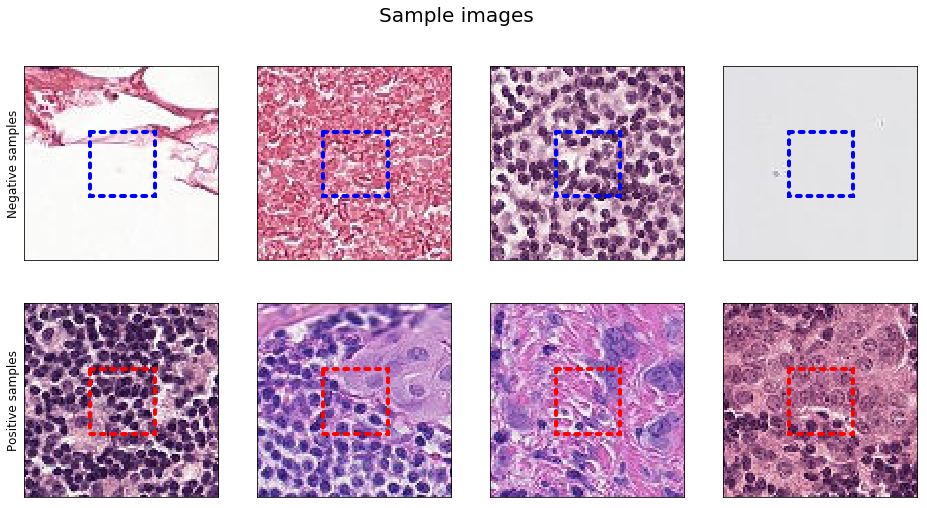

In [4]:
# random sampling
shuffled_data = shuffle(labels)

fig = plt.figure(figsize=(16,8))
fig.suptitle('Sample images',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:4]):
    path = os.path.join(train_path, idx)
    ax = fig.add_subplot(2,4,i+1,xticks =[], yticks=[])  # add subplots
    plt.imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax.add_patch(box)
    if i==0:
        ax.set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:4]):
    path = os.path.join(train_path, idx)
    ax = fig.add_subplot(2,4,i+5,xticks =[], yticks=[])  # add subplots
    plt.imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax.add_patch(box)
    if i==0:
        ax.set_ylabel('Positive samples', size='large')
plt.savefig('Sample_images.jpg')

# Data Distribution

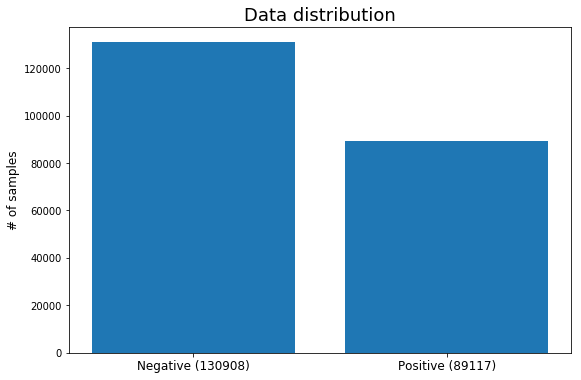

In [5]:
# Plot data distribution

y = np.asarray(shuffled_data['label']) # Convert the labels dataframe to a numpy array

unique, counts = np.unique(y, return_counts=True) 

for i in range(len(unique)):
    if unique[i] ==0:
        N_Negative = counts[i]
    elif unique[i] ==1:
        N_Positive = counts[i]
fig = plt.figure(figsize=(9,6))
plt.bar([0,1],[N_Negative,N_Positive])
plt.xticks([0, 1], ['Negative ({})'.format(N_Negative),'Positive ({})'.format(N_Positive)], size='large')
plt.ylabel('# of samples', size='large')
plt.title('Data distribution',fontsize=18)
plt.savefig('Data_distribution.jpg')

# Image Statistics and Outliers

In [6]:
# As we count the statistics, we can check if there are any completely black or white images (outliers)
dark_thres = 10 / 255      # If no pixel reaches this threshold, image is considered too dark 
bright_thres = 245 / 255   # If no pixel is under this threshold, image is considerd too bright
too_dark_idx = []
too_bright_idx = []

x_total = np.zeros(3)
x2_total = np.zeros(3)
counted_ones = 0
for i, idx in tqdm_notebook(enumerate(shuffled_data['id']), 'computing statistics...(220025 it total)'):
    path = os.path.join(train_path, idx)
    imagearray = (readImage(path + '.tif')/255).reshape(-1,3) # Normalized to 0~1
    # is this too dark
    if(imagearray.max() < dark_thres):
        too_dark_idx.append(idx)
        continue # do not include in statistics
    # is this too bright
    if(imagearray.min() > bright_thres):
        too_bright_idx.append(idx)
        continue # do not include in statistics
    x_total += imagearray.mean(axis=0)
    x2_total += (imagearray**2).mean(axis=0)
    counted_ones += 1
    
rgb_mean = x_total/counted_ones
rgb_std = np.sqrt(x2_total/counted_ones - rgb_mean**2)
print(rgb_mean,rgb_std) # plot image statistics: mean brightness and standard derivation


[0.70244707 0.54624322 0.69645334] [0.23889325 0.28209431 0.21625058]


In [7]:
print('Extremely dark image count: {}'.format(len(too_dark_idx)))
print('Extremely bright image count: {}'.format(len(too_bright_idx)))

Extremely dark image count: 1
Extremely bright image count: 6


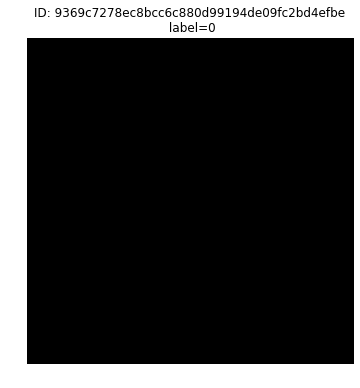

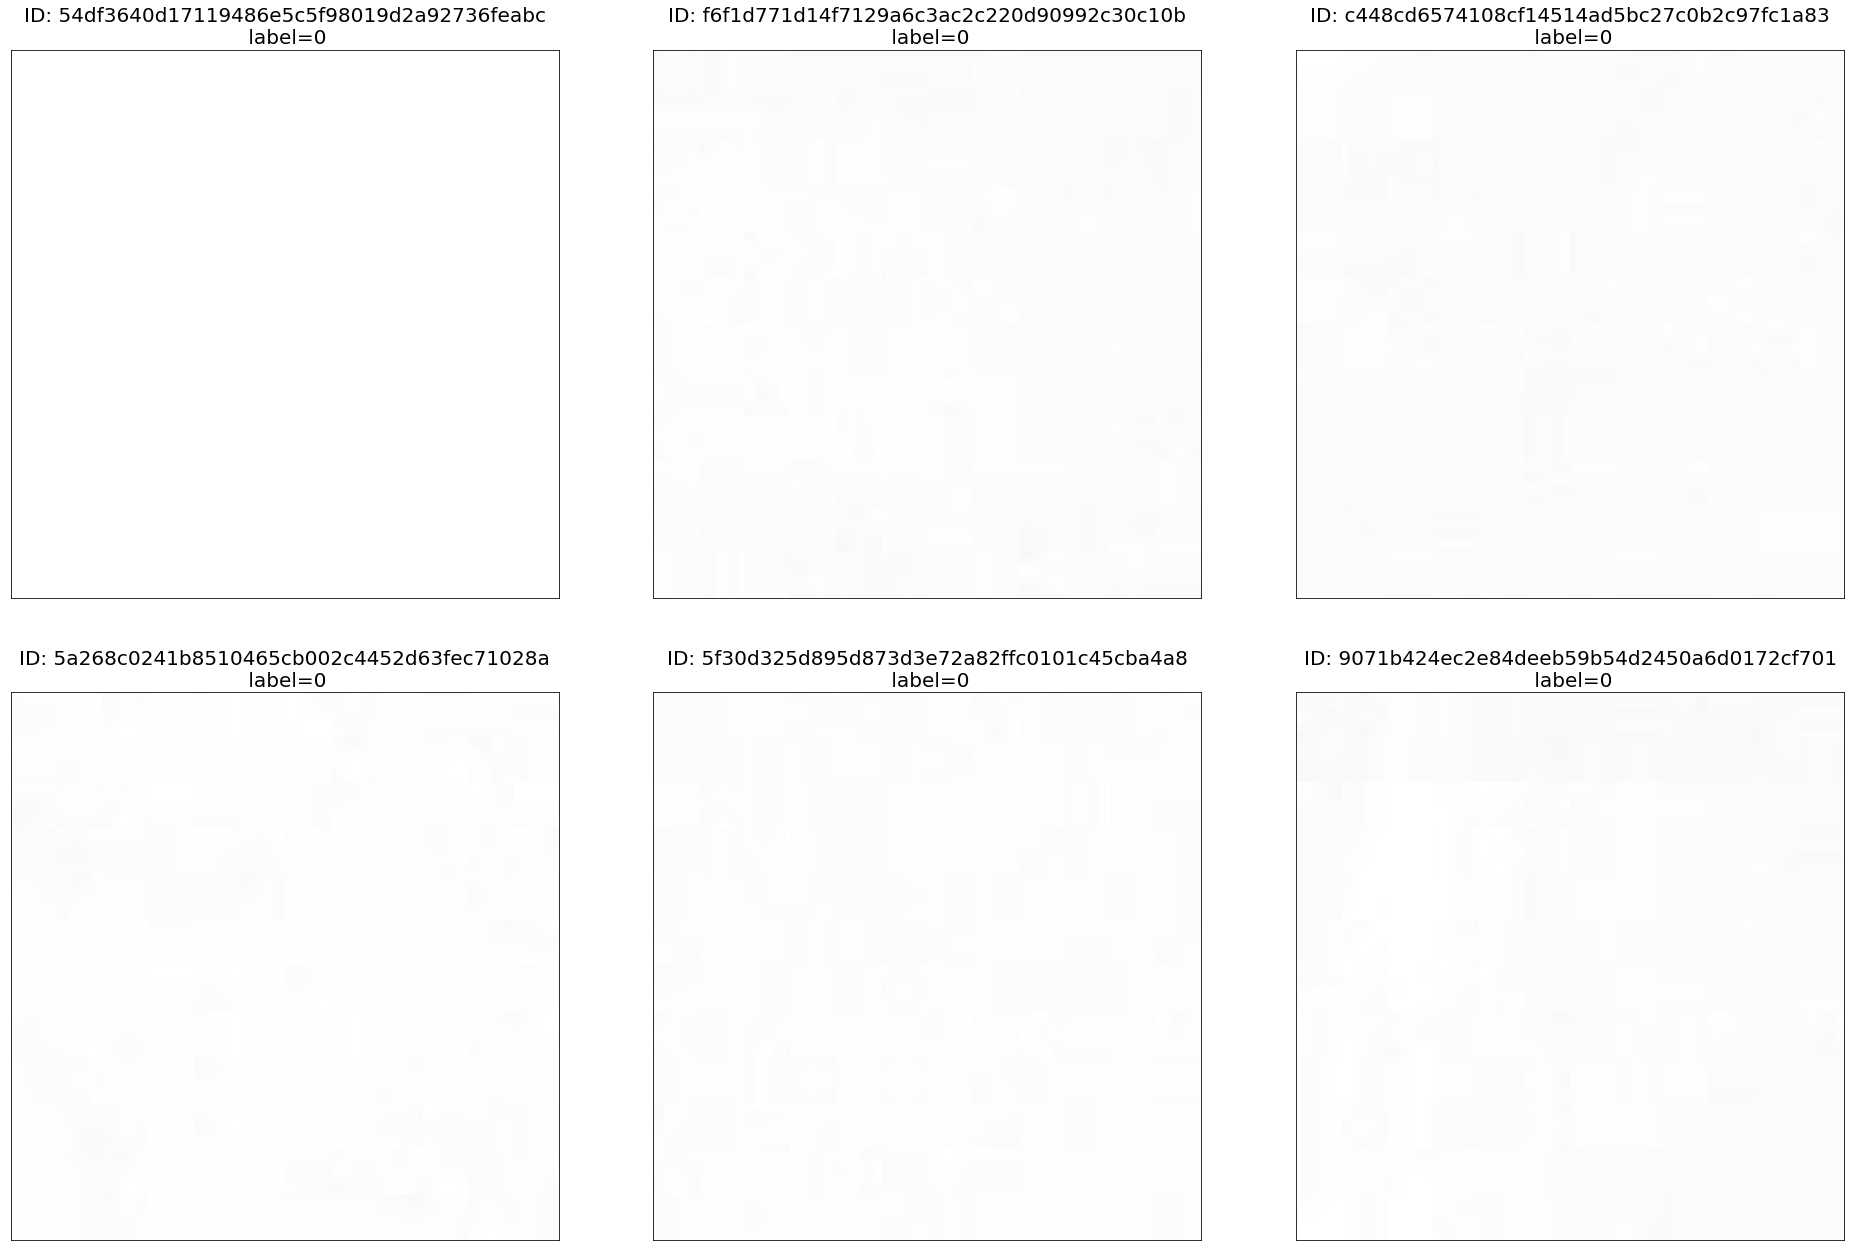

In [8]:
# Plot the extremely dark or bright images

# Extremely dark image
idx = too_dark_idx[0]
lbl = shuffled_data[shuffled_data['id'] == idx]['label'].values[0]
path = os.path.join(train_path, idx)
fig = plt.figure(figsize=(9,6))
plt.imshow(readImage(path + '.tif'))
plt.title('ID: '+idx + '\n label=' + str(lbl), fontsize = 12)
plt.axis('off')
plt.savefig('Extreme_Dark_Img.jpg')


# Extremely bright images
fig = plt.figure(figsize=(27,18))
i = 0
for idx in np.asarray(too_bright_idx)[:min(6, len(too_bright_idx))]:
    lbl = shuffled_data[shuffled_data['id'] == idx]['label'].values[0]
    path = os.path.join(train_path, idx)
    ax = fig.add_subplot(2,3,i+1,xticks =[], yticks=[]) 
    plt.imshow(readImage(path + '.tif'))
    ax.set_title('ID: '+idx + '\n label=' + str(lbl), fontsize = 20)
    i += 1
plt.tight_layout()
plt.savefig('Extreme_Bright_Img.jpg')



# Exploratory Visualization

In [9]:
# Due to limited RAM, only a subset of images are used for the following exploration 
N = 20000
# allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
Img_subset = np.zeros([N,96,96,3],dtype=np.uint8) 
#convert the labels to a numpy array too
Label_subset = np.asarray(shuffled_data['label'])[0:N]
#read images one by one, tdqm notebook displays a progress bar
for i, idx in tqdm_notebook(enumerate(shuffled_data['id']), total=N):
    if i == N:
        break
    path = os.path.join(train_path, idx)
    Img_subset[i] = readImage(path + '.tif')  
    

In [10]:
# Separate positive and negative samples
positive_samples = Img_subset[Label_subset==1]
negative_samples = Img_subset[Label_subset==0]

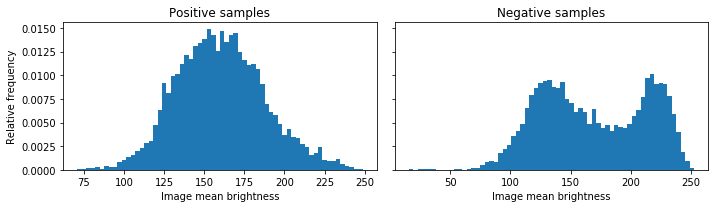

In [11]:
# Mean image brightness distribution for positive and negative samples
N_of_bins = 64 # Allocate bins to show the distirbution 
fig, axes = plt.subplots(1,2,sharey=True,figsize =(10,3))
axes[0].hist(np.mean(positive_samples, axis = (1,2,3)),bins = N_of_bins, density = True)
axes[1].hist(np.mean(negative_samples, axis = (1,2,3)),bins = N_of_bins, density = True)
axes[0].set_title('Positive samples')
axes[1].set_title('Negative samples')
axes[0].set_xlabel('Image mean brightness')
axes[1].set_xlabel('Image mean brightness')
axes[0].set_ylabel('Relative frequency')
plt.tight_layout()
plt.savefig('Img_Mean_Brightness_Distribution.jpg')